In [1]:
import awkward as ak
import numpy as np
import time
# print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt

plt.style.use([hep.style.CMS, hep.style.firamath])
import hist
from hist.intervals import ratio_uncertainty
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

from python.plugins import runCoffeaJob
from python.triggerProcessor import triggerProcessor, applyPrescales
from dask.distributed import Client

In [3]:
# in_year = '2016APV'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentL1pt_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [4]:
# in_year = '2016'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentL1pt_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [5]:
# in_year = '2017'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentL1pt_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [6]:
# in_year = '2018'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing =False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentL1pt_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [7]:
from scipy.optimize import minimize, curve_fit
from scipy.stats import rv_continuous, norm
from scipy.special import erf, erfinv

def fit_function(x, b, c):
    # y = a+0.5*(1-a)*(1+erf((x-b)/c))
    y = 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    return y
#### define custom error function using scipy.stats rv_continuous --> will automatically inherit MLE fit

class cust_erf(rv_continuous):
    def _pdf(self, x, b, c):
        # return a+0.5*(1-a)*(1+erf((x-b)/c))
        return 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    #### use rv_continuous scale and loc to compute x->(x-loc)/scale
fit_func = cust_erf(name='erf')
print("rv_cont fit function: ", fit_func)

#### params are b,c
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    x0 = [np.min(x), np.min(x)/5]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    # b, c, loc, scale = fit_func.fit(data, *popt, floc = 0., fscale = 1.0)
    print("Basic fit results: ", popt)
    return popt

from python.plugins import checkdir
def plot_turnOn(result, HLT, label):
    hist_trigEff = result['hist_trigEff_ptCut']
    hist_trigRef = result['hist_trigRef']
    hist_pt = result['hist_pt']
    HLT_paths = [path for path in list(hist_trigEff.project("HLT_cat").axes[0])]
    dataset = hist_trigEff[{"HLT_cat":slice(0,hist.overflow-1,sum)}].axes[0][0]
    os_path = 'plots/triggerStudies'+ dataset+'/'
    checkdir(os_path)
    print('HLT_paths:', HLT_paths)
    trigThresh = [int(path.replace(HLT, '')) for path in HLT_paths]
    turnOnPts = {}
    turnOnPts_ptCut = {}
    for i in np.arange(len(HLT_paths)):
        path = HLT_paths[i]
        print("Path = ", path)
        print("dataset: ", dataset)
        # print("trigeffvalues for path: ", hist_trigEff[{"HLT_cat":path}])
        #### numerator is number of events that belong to trigger path below and have pt > current trigger thresh
        numerator = hist_trigEff[{"HLT_cat":path}].values()[0]
        #### denominator is number of events in trigger below
        denominator = hist_trigRef[{"HLT_cat":path}].values()[0]
        num = numerator[denominator > 0]
        denom = denominator[denominator > 0]
        efficiency = num / denom
        # eff_hist = np.where(denominator > 0, numerator/denominator, 0)
        eff_hist = np.divide(
                hist_trigEff[{"HLT_cat":path}].values(),
                hist_trigRef[{"HLT_cat":path}].values(),
                out=np.empty(np.array(hist_trigRef[{"HLT_cat":path}].values()).shape).fill(np.nan),
                where=hist_trigRef[{"HLT_cat":path}].values()!= 0)[0]
        err_up, err_dn = ratio_uncertainty(hist_trigEff[{"HLT_cat":path}].values(), hist_trigRef[{"HLT_cat":path}].values(), 'efficiency')
        # print(err_up[0], err_dn[0])
        eff_hist_err = np.array([np.divide(
                np.sqrt(hist_trigEff[{"HLT_cat":path}].values())/2,
                hist_trigRef[{"HLT_cat":path}].values(),
                out=np.empty(np.array(hist_trigRef[{"HLT_cat":path}].values()).shape).fill(np.nan),
                where=hist_trigRef[{"HLT_cat":path}].values()!= 0)[0], np.zeros_like(hist_trigRef[{"HLT_cat":path}].values())[0]])
        pt_centers = hist_trigEff.axes['pt'].centers[denominator > 0]
        # print("Pt centers: ", pt_centers)
        # print("Pt edges: ",  hist_trigEff.axes['pt'].edges)
        #### plot original numerator and denominator histograms
        fig, ax = plt.subplots(1, 1)
        hist_trigEff[{"HLT_cat":path}].plot1d(ax=ax)
        hist_trigRef[{"HLT_cat":path}].plot1d(ax=ax)
        ax.set_title("Events in HLT " + HLT_paths[i-1])
        ax.set_xlabel("Leading Jet pT (GeV)")
        ax.set_ylim(1, None)
        ax.legend(["Numerator", "Numerator_ptCut", "Denominator"])
        plt.savefig(os_path + 'numDenom_HLT_' + path + ".png")
        #### Make custom fit function for the efficiencies
        if len(efficiency) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.set_ylim([-0.01, 1.1])
            ### only fit points after trigger threshold
            eff_turnon_id = np.min(np.argwhere(trigThresh[i] <= pt_centers))
            if i > 2:
                xdata = pt_centers[eff_turnon_id+2:]
                ydata = efficiency[eff_turnon_id+2:]
            else:
                xdata = pt_centers[eff_turnon_id:]
                ydata = efficiency[eff_turnon_id:]
            popt = fit_trigEff(xdata, ydata)
            # b_mle, c_mle, popt = fit_trigEff(pt_centers, efficiency)
            xpts = np.linspace(pt_centers[eff_turnon_id], 2400, int((2400-pt_centers[eff_turnon_id])))
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            b, c = popt
            xdata = pt_centers[eff_turnon_id:]
            ydata = efficiency[eff_turnon_id:]
            def NLL(params):
                b = params[0]
                c = params[1]
                y = 0.5*(1+erf((xdata-b)/(np.sqrt(2)*c)))
                return -1*norm(y, params[2]).logpdf(ydata).sum()
            # res = minimize(NLL, [popt[0], popt[1], 1])
            res = minimize(NLL, [np.min(xdata), np.min(xdata)/5, 1])
            b_mle, c_mle, s_mle = res.x
            print("MLE results ", res.x)
            to_pt = (np.sqrt(2)*c*erfinv(2*0.99-1)) + b
            to_pt_mle = (np.sqrt(2)*c_mle*erfinv(2*0.99-1)) + b_mle
            turnOnPts[path] = [to_pt, to_pt_mle]
            hep.histplot(eff_hist, hist_trigEff.axes['pt'].edges, ax = ax, label='HLT_'+path, yerr=np.array([err_up[0],err_dn[0]]), histtype='errorbar', color = 'black', marker =["o"], markersize=6,)
            ax.plot(xpts, fit_function(xpts, *popt), label = "Fit; to_pt = %.f"%to_pt, color='red')
            hep.cms.label("Preliminary", lumi = label, data = True, loc=0, ax=ax, fontsize=18);
            #ax.plot(xpts, fit_function(xpts, b_mle, c_mle), label = "MLE fit; to_pt = %.f"%to_pt_mle)
            ax.set_xlabel("Leading Jet pT (GeV)")
            ax.legend()
            plt.savefig(os_path + 'efficiency_HLT_'+path + ".png")
    #### plot total leading jet pt for reference
    fig, ax = plt.subplots(1, 1)
#     hist_pt.plot1d(ax=ax)
    pt_hist = hist_trigEff[{"dataset":sum}]
    pt_hist.plot1d(ax=ax, overlay="HLT_cat", stack = True)
    ax.set_title("All events")
    ax.set_xlabel("Leading Jet pT (GeV)")
    ax.set_ylim(1, None)
    ax.set_xlim([180., 3200.])
    plt.legend()
    plt.savefig(os_path + 'HLT_' + path + ".png")
    
    return turnOnPts


# lumi = {'2018' : 59.74,
#         '2017': 41.48,
#         '2016': 36.33 
#        }

#'2016APV':19.5
#"2016":16.8

rv_cont fit function:  <__main__.cust_erf object at 0x7f37c175dd20>


In [8]:
# HLT = 'AK8PFJet'
# with open('coffeaOutput/triggerAssignmentL1pt_JetHT_2016_AK8PFJet.pkl', "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT, label=r'2016 APV - 19.5' )
# print(turnOnPts)

In [9]:
# HLT = 'AK8PFJet'
# with open('coffeaOutput/triggerAssignmentL1pt_JetHT_2017_AK8PFJet.pkl', "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT, label=r'2017 - 41.48', )
# print(turnOnPts)

In [10]:
# HLT = 'AK8PFJet'
# with open('coffeaOutput/triggerAssignmentL1pt_JetHT_2018_AK8PFJet.pkl', "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT, label=r'2018 - 59.74', )
# print(turnOnPts)

In [11]:
# HLT = 'AK8PFJet'
# with open('coffeaOutput/triggerAssignmentL1pt_JetHT_2016_AK8PFJet.pkl', "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT, label=r'Late 2016 - 16.8' )
# print(turnOnPts)

In [12]:
# HLT = 'AK8PFJet'
# with open("coffeaOutput/triggerAssignmentL1pt_QCDsim_2017_AK8PFJet_NewHist.pkl", "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT, label=r'2017 - 41.48')
# print(turnOnPts)

In [13]:
# HLT = 'AK8PFJet'
# result = util.load('coffeaOutput/triggerAssignment_QCDsim_2018_AK8PFJet_NewHist.coffea')
# turnOnPts = plot_turnOn(result, HLT, label=r'2018 - 59.74')
# print(turnOnPts)

In [14]:
newl12016APV = {'AK8PFJet60': [139.5571999490993, 245.53535229795398], 'AK8PFJet80': [208.43956364614138, 245.8326001605219], 
                 'AK8PFJet140': [290.39564432515516, 246.01436032449925], 'AK8PFJet200': [386.9131362346668, 316.5993928376519], 
                 'AK8PFJet260': [458.155057383878, 386.9622490345946], 'AK8PFJet320': [550.9902289618454, 527.4372732800409], 
                 'AK8PFJet400': [648.8680463439613, 597.869306052639], 'AK8PFJet450': [733.6385194424329, 668.2051368021362], 
                 'AK8PFJet500': [821.4588783253023, 738.5446622605812]}
newl12016 = {'AK8PFJet60': [139.5571999490993, 245.53535229795398], 'AK8PFJet80': [208.43956364614138, 245.8326001605219], 
             'AK8PFJet140': [290.39564432515516, 246.01436032449925], 'AK8PFJet200': [386.9131362346668, 316.5993928376519], 
             'AK8PFJet260': [458.155057383878, 386.9622490345946], 'AK8PFJet320': [550.9902289618454, 527.4372732800409], 
             'AK8PFJet400': [648.8680463439613, 597.869306052639], 'AK8PFJet450': [733.6385194424329, 668.2051368021362], 
             'AK8PFJet500': [821.4588783253023, 738.5446622605812]}
newl12017 = {'AK8PFJet80': [160.52022125699813, 245.85202220965644], 'AK8PFJet140': [277.85271111436055, 246.10402869403651], 
             'AK8PFJet200': [318.6411767123043, 316.6185299473434], 'AK8PFJet260': [459.1656517376684, 386.9894328364755], 
             'AK8PFJet320': [562.0252237627351, 527.4792214934412], 'AK8PFJet400': [643.851069453488, 597.9284546318087], 
             'AK8PFJet450': [705.0788178200379, 668.2475354949781], 'AK8PFJet500': [762.7485185854354, 738.5812156526756], 
             'AK8PFJet550': [815.002094554022, 808.9197189538069], 'AK8PFJet60': [205.05400523227544, 245.684911515468]}
newl12018 = {'AK8PFJet60': [-332.1769145662199, 245.650955165529], 'AK8PFJet80': [160.89471879512197, 245.86440968922605], 
             'AK8PFJet140': [274.1725162164536, 246.08377938512882], 'AK8PFJet200': [395.60974887544114, 316.5756365655121], 
             'AK8PFJet260': [475.25798095173286, 386.9816221068269], 'AK8PFJet320': [571.680946693499, 527.4729507490305], 
             'AK8PFJet400': [655.696422385234, 597.913991324915], 'AK8PFJet450': [711.5656697563014, 668.232929496411], 
             'AK8PFJet500': [768.1579923535201, 738.5606165982504], 'AK8PFJet550': [822.2737265359849, 808.8892513751434]}
JetHT2016_L1 = {'AK8PFJet40':0.,
                 'AK8PFJet60': 140., 
                 'AK8PFJet80': 210., 
                 'AK8PFJet140': 290., 
                 'AK8PFJet200': 380., 
                 'AK8PFJet260': 450., 
                 'AK8PFJet320': 550., 
                 'AK8PFJet400': 640., 
                 'AK8PFJet450': 690., 
                 'AK8PFJet500': 820.}
JetHT2016APV_L1 = {'AK8PFJet40':0., 
                     'AK8PFJet60': 140, 
                     'AK8PFJet80': 210., 
                     'AK8PFJet140': 290., 
                     'AK8PFJet200': 380., 
                     'AK8PFJet260': 450., 
                     'AK8PFJet320': 550., 
                     'AK8PFJet400': 640., 
                     'AK8PFJet450': 730., 
                     'AK8PFJet500': 820.}
JetHT2017_L1 = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 160., 
                 'AK8PFJet140': 270., 
                 'AK8PFJet200': 310., 
                 'AK8PFJet260': 450., 
                 'AK8PFJet320': 560., 
                 'AK8PFJet400': 640., 
                 'AK8PFJet450': 700., 
                 'AK8PFJet500': 760., 
                 'AK8PFJet550': 810.}
JetHT2018_L1 = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0.,
                 'AK8PFJet80': 160., 
                 'AK8PFJet140': 270., 
                 'AK8PFJet200': 390., 
                 'AK8PFJet260': 470., 
                 'AK8PFJet320': 570., 
                 'AK8PFJet400': 650., 
                 'AK8PFJet450': 710., 
                 'AK8PFJet500': 760., 
                 'AK8PFJet550': 820.}

newnew2016APV = {'AK8PFJet80': [206.71681401992288, 245.80203214860862], 'AK8PFJet140': [295.5153287657522, 246.03857544743312], 
                 'AK8PFJet200': [383.2695153254568, 316.57670808881846], 'AK8PFJet260': [454.68629962052887, 386.9356446549318], 
                 'AK8PFJet320': [538.479400720177, 527.4299778082257], 'AK8PFJet400': [633.9522294146702, 597.8526203266226], 
                 'AK8PFJet450': [694.4927945859686, 668.1781457638338], 'AK8PFJet500': [755.7150720100303, 738.5071435612301], 
                 'AK8PFJet60': [260.3094007879748, 245.58375418569005]}
newnew2016 = {'AK8PFJet60': [100.40608316724649, 245.5298192522847], 'AK8PFJet80': [195.51695202868575, 245.83058902029856], 
              'AK8PFJet140': [301.58382693635207, 246.0134529470037], 'AK8PFJet200': [383.1741445983902, 316.5976947954485], 
              'AK8PFJet260': [454.1467647001151, 386.9565338107493], 'AK8PFJet320': [542.2012876755962, 527.4346186253939], 
              'AK8PFJet400': [639.6423834136942, 597.8660384096415], 'AK8PFJet450': [700.1192047651415, 668.1948138872644], 
              'AK8PFJet500': [758.8996263151007, 738.5270825844352]}
newnew2017 = {'AK8PFJet80': [158.8217677667153, 245.85067329468905], 'AK8PFJet140': [277.53252830819343, 246.10363397245038], 
              'AK8PFJet200': [379.59717106703374, 316.6181201895635], 'AK8PFJet260': [456.7391589335493, 386.9886624211972], 
              'AK8PFJet320': [555.9776150691441, 527.4777453755719], 'AK8PFJet400': [639.6369731592267, 597.9271394472382], 
              'AK8PFJet450': [695.3987038715835, 668.2434033060491], 'AK8PFJet500': [751.8967587418315, 738.5765296365711], 
              'AK8PFJet550': [807.2443310090212, 808.9167200413362], 'AK8PFJet60': [-877.7123828596834, 245.6840972118489]}
newnew2018 = {'AK8PFJet60': [-521.0313418480091, 244.13319163187657], 'AK8PFJet80': [-80.00217978293904, 245.39571343362627], 
              'AK8PFJet140': [297.43543263310437, 245.9177393056605], 'AK8PFJet200': [406.69416502137796, 316.6602058820866], 
              'AK8PFJet260': [489.92570083604835, 387.11110509891284], 'AK8PFJet320': [571.6177039744604, 527.4705925839824], 
              'AK8PFJet400': [657.9603636190895, 597.9575129248651], 'AK8PFJet450': [718.7886591113057, 668.2598124896558], 
              'AK8PFJet500': [772.2281837110286, 738.5825096131468], 'AK8PFJet550': [821.0378179237298, 808.9028067019016]}
JetHT2016_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 100., 
                 'AK8PFJet80': 200., 
                 'AK8PFJet140': 260., 
                 'AK8PFJet200': 350., 
                 'AK8PFJet260': 420., 
                 'AK8PFJet320': 530., 
                 'AK8PFJet400': 620., 
                 'AK8PFJet450': 690., 
                 'AK8PFJet500': 740.}
JetHT2016APV_new = {'AK8PFJet40':0., 
                     'AK8PFJet60': 0, 
                     'AK8PFJet80': 220., 
                     'AK8PFJet140': 270., 
                     'AK8PFJet200': 360., 
                     'AK8PFJet260': 440., 
                     'AK8PFJet320': 530., 
                     'AK8PFJet400': 630., 
                     'AK8PFJet450': 690., 
                     'AK8PFJet500': 750.}
JetHT2017_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 200., 
                 'AK8PFJet140': 260., 
                 'AK8PFJet200': 340., 
                 'AK8PFJet260': 420., 
                 'AK8PFJet320': 530., 
                 'AK8PFJet400': 620., 
                 'AK8PFJet450': 680., 
                 'AK8PFJet500': 745., 
                 'AK8PFJet550': 807.}
JetHT2018_new = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0.,
                 'AK8PFJet80': 0., 
                 'AK8PFJet140': 260., 
                 'AK8PFJet200': 360., 
                 'AK8PFJet260': 440., 
                 'AK8PFJet320': 550., 
                 'AK8PFJet400': 630., 
                 'AK8PFJet450': 700., 
                 'AK8PFJet500': 750., 
                 'AK8PFJet550': 810.}



turnOnPts_2016_QCDflat = {'AK8PFJet40':0.,
                          'AK8PFJet60': 106.79400044725446, 
                          'AK8PFJet80': 169.96352855878737, 
                          'AK8PFJet140': 265.2873364497926, 
                          'AK8PFJet200': 315.1712855987987, 
                          'AK8PFJet260': 385.9414264230047, 
                          'AK8PFJet320': 456.1785495557566, 
                          'AK8PFJet400': 528.4054384945691, 
                          'AK8PFJet450': 599.9567915817205, 
                          'AK8PFJet500': 671.8599581978826}

turnOnPts_2017_QCD_flat = {'AK8PFJet40':0.,
                           'AK8PFJet60': 78.72682467365811, 
                           'AK8PFJet80': 114.26008394028244, 
                           'AK8PFJet140': 262.69051582382326, 
                           'AK8PFJet200': 315.5082701033607, 
                           'AK8PFJet260': 391.2706193753585, 
                           'AK8PFJet320': 461.86703035451836, 
                           'AK8PFJet400': 545.2806371181599, 
                           'AK8PFJet450': 611.8168127002015, 
                           'AK8PFJet500': 681.8828608405956, 
                           'AK8PFJet550': 725.799090910656}

turnOnPts_2018_QCDflat = {'AK8PFJet15': 0.,
                          'AK8PFJet25': 0.,
                          'AK8PFJet40': 0.,
                          'AK8PFJet60': 0.,
                          'AK8PFJet80': 0.,
                          'AK8PFJet140': 255.02381002773194, 
                          'AK8PFJet200': 313.2026733979357, 
                          'AK8PFJet260': 388.2175317071178, 
                          'AK8PFJet320': 459.1304096129003, 
                          'AK8PFJet400': 530.7709332894112, 
                          'AK8PFJet450': 599.485074238053, 
                          'AK8PFJet500': 669.532328119605, 
                          'AK8PFJet550': 706.4936306567531}

In [15]:
# in_year = '2016APV'
# data_bool = True
# winterfell = False
# processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2016APV_L1.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescalesL1_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [16]:
# in_year = '2016'
# data_bool = True
# winterfell = False
# processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2016_L1.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescalesL1_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [17]:
in_year = '2017'
data_bool = True
winterfell = False
processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2017_L1.values())), data = data_bool)
datastring = "JetHT" if processor.data == True else "QCDsim"
if processor.data==False and winterfell:
    filename = "QCD_flat_files.json"
elif processor.data==False:
    filename = "fileset_QCD.json"
else:
    filename = "fileset_JetHT_wRedirs.json"
result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
with open('coffeaOutput/applyPrescalesL1_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
    pickle.dump( result, f)

Running over datasets  dict_keys(['/JetHT/Run2017B-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD', '/JetHT/Run2017C-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD', '/JetHT/Run2017D-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD', '/JetHT/Run2017E-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD', '/JetHT/Run2017F-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD'])
Running on LPC Condor
[########                                ] | 21% Completed |  1min 19.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 65746941.0: TOOL at 131.225.190.235 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/lmhay/tmpu0zxcgue/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/6941/0/cluster65746941.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK8PF.junc.txt


[############################            ] | 71% Completed |  1min 45.5s

Task exception was never retrieved
future: <Task finished name='Task-5010' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError


{'hist_pt': Hist(########################] | 100% Completed | 26min 49.9s
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.23893e+08, variance=1.23893e+08) (WeightedSum(value=1.23904e+08, variance=1.23904e+08) with flow), 'hist_pt_byHLTpath': Hist(
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.17062e+10, variance=3.93306e+14) (WeightedSum(value=1.17

In [18]:
in_year = '2018'
data_bool = True
winterfell = False
processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2018_L1.values())), data = data_bool)
datastring = "JetHT" if processor.data == True else "QCDsim"
if processor.data==False and winterfell:
    filename = "QCD_flat_files.json"
elif processor.data==False:
    filename = "fileset_QCD.json"
else:
    filename = "fileset_JetHT_wRedirs.json"
result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
with open('coffeaOutput/applyPrescalesL1_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
    pickle.dump( result, f)

Running over datasets  dict_keys(['/JetHT/Run2018A-UL2018_MiniAODv2_NanoAODv9-v2/NANOAOD', '/JetHT/Run2018B-UL2018_MiniAODv2_NanoAODv9-v1/NANOAOD', '/JetHT/Run2018C-UL2018_MiniAODv2_NanoAODv9-v1/NANOAOD', '/JetHT/Run2018D-UL2018_MiniAODv2_NanoAODv9-v2/NANOAOD'])
Running on LPC Condor
[                                        ] | 0% Completed | 22.4sin 54.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 65747128.0: TOOL at 131.225.190.235 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/lmhay/tmpk4513vig/correctionFiles/SFs/bquark/DeepCSV_106XUL17SF_V2.csv; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/7128/0/cluster65747128.proc0.subproc0.tmp/correctionFiles/JERs/MC/fatJet_jerc.json


[                                        ] | 0% Completed | 24.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 65747130.0: TOOL at 131.225.190.235 failed to send file(s) to <131.225.189.168:9618>; SCHEDD at 131.225.189.168 failed to create directory /storage/local/data1/condor/spool/7130/0/cluster65747130.proc0.subproc0.tmp/correctionFiles/puWeights/2018_UL: No such file or directory (errno 2)


[                                        ] | 0% Completed | 36.8s

Task exception was never retrieved
future: <Task finished name='Task-187082' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError
Task exception was never retrieved
future: <Task finished name='Task-187080' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    

{'hist_pt': Hist(########################] | 100% Completed | 36min 21.4s
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.23984e+08, variance=1.23984e+08) (WeightedSum(value=1.23992e+08, variance=1.23992e+08) with flow), 'hist_pt_byHLTpath': Hist(
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.45866e+10, variance=4.49847e+14) (WeightedSum(value=1.45

In [19]:
# in_year = '2016APV'
# data_bool = True
# winterfell = True
# processor = applyPrescales(year = in_year, trigger = 'PFJet', turnOnPts = np.array(list(JetHT2016APV_ver2.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescales_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [20]:
def plotPrescales(result, year, label):
    hist_pt = result['hist_pt'][{'dataset':sum}]
    hist_pt_vals = np.where(hist_pt.values()==0., np.empty(np.array(hist_pt.values()).shape).fill(np.nan), hist_pt.values())
    hist_pt_byHLTpath = result['hist_pt_byHLTpath'][{'dataset':sum}]
    byHLTpath_vals = np.where(hist_pt_byHLTpath.values()==0., np.empty(np.array(hist_pt_byHLTpath.values()).shape).fill(np.nan), hist_pt_byHLTpath.values())
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams["figure.figsize"] = (20,10)
    fig, axs = plt.subplots(1, 2)      
    print(hist_pt)
    # hist_pt.plot(ax = axs[0], overlay='HLT_cat')
    axs[0].set_yscale('log')
    axs[0].set_ylim([0.0, 1.0e10])
    axs[0].set_title('Sorted by HLT w/ prescale applied', pad=32)
    hep.histplot(hist_pt_vals, hist_pt.axes['pt'].edges, ax = axs[0],histtype='step')
    hep.histplot(byHLTpath_vals, hist_pt_byHLTpath.axes['pt'].edges, ax = axs[1],histtype='fill')
    axs[1].set_yscale('log')
    axs[1].set_ylim([0.0, 1.0e10])
    axs[1].set_title('Doubles removed w/ prescale applied', pad=32)
    hep.cms.label("Preliminary", lumi = label, data = True, loc=2, ax=axs[0], fontsize=18);
    hep.cms.label("Preliminary", lumi = label, data = True, loc=2, ax=axs[1], fontsize=18);

    plt.rc('legend',fontsize='small')
    print(hist_pt.axes)
    axs[0].legend([cat for cat in hist_pt.project('HLT_cat').axes[0]])
    axs[1].legend([cat for cat in hist_pt_byHLTpath.project('HLT_cat').axes[0]])
    dataset = 'JetHT' + str(year)
    os_path = 'plots/triggerStudies'+ dataset + '/'
    checkdir(os_path)
    plt.savefig(os_path + 'applyPrescales' + str(year) + ".png")


[61738631.]
Hist(
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=6.17354e+07, variance=6.17354e+07) (WeightedSum(value=6.17386e+07, variance=6.17386e+07) with flow)
(StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'), Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'))


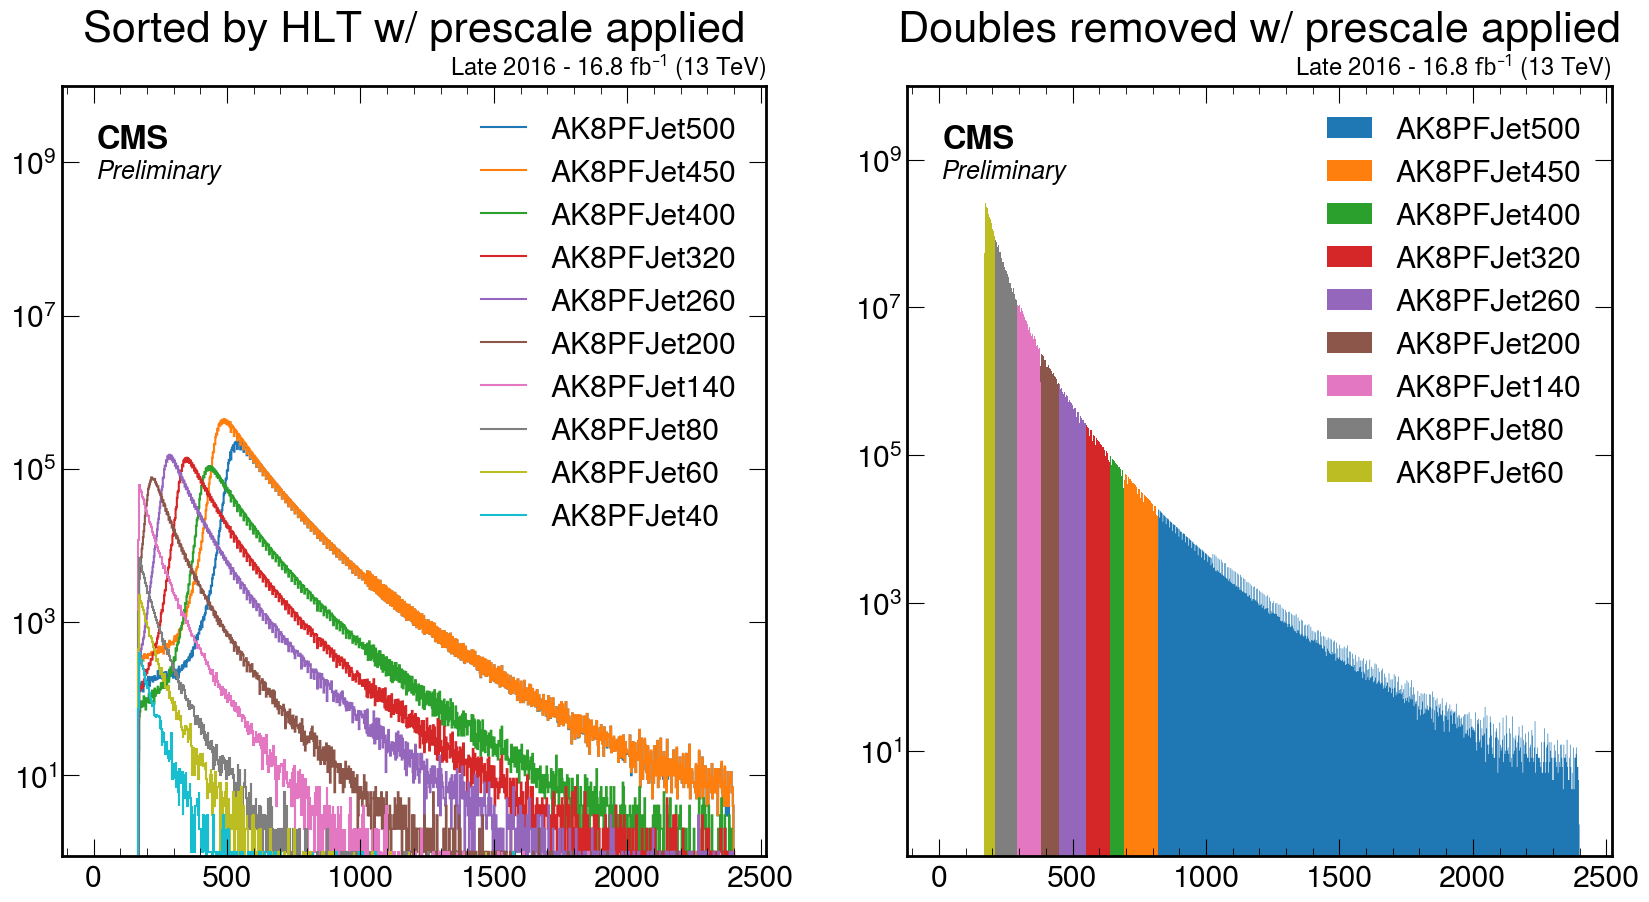

In [21]:
with open("coffeaOutput/applyPrescalesL1_JetHT_2016_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2016', label=r'Late 2016 - 16.8' )

Hist(
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.23893e+08, variance=1.23893e+08) (WeightedSum(value=1.23904e+08, variance=1.23904e+08) with flow)
(StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'), Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'))


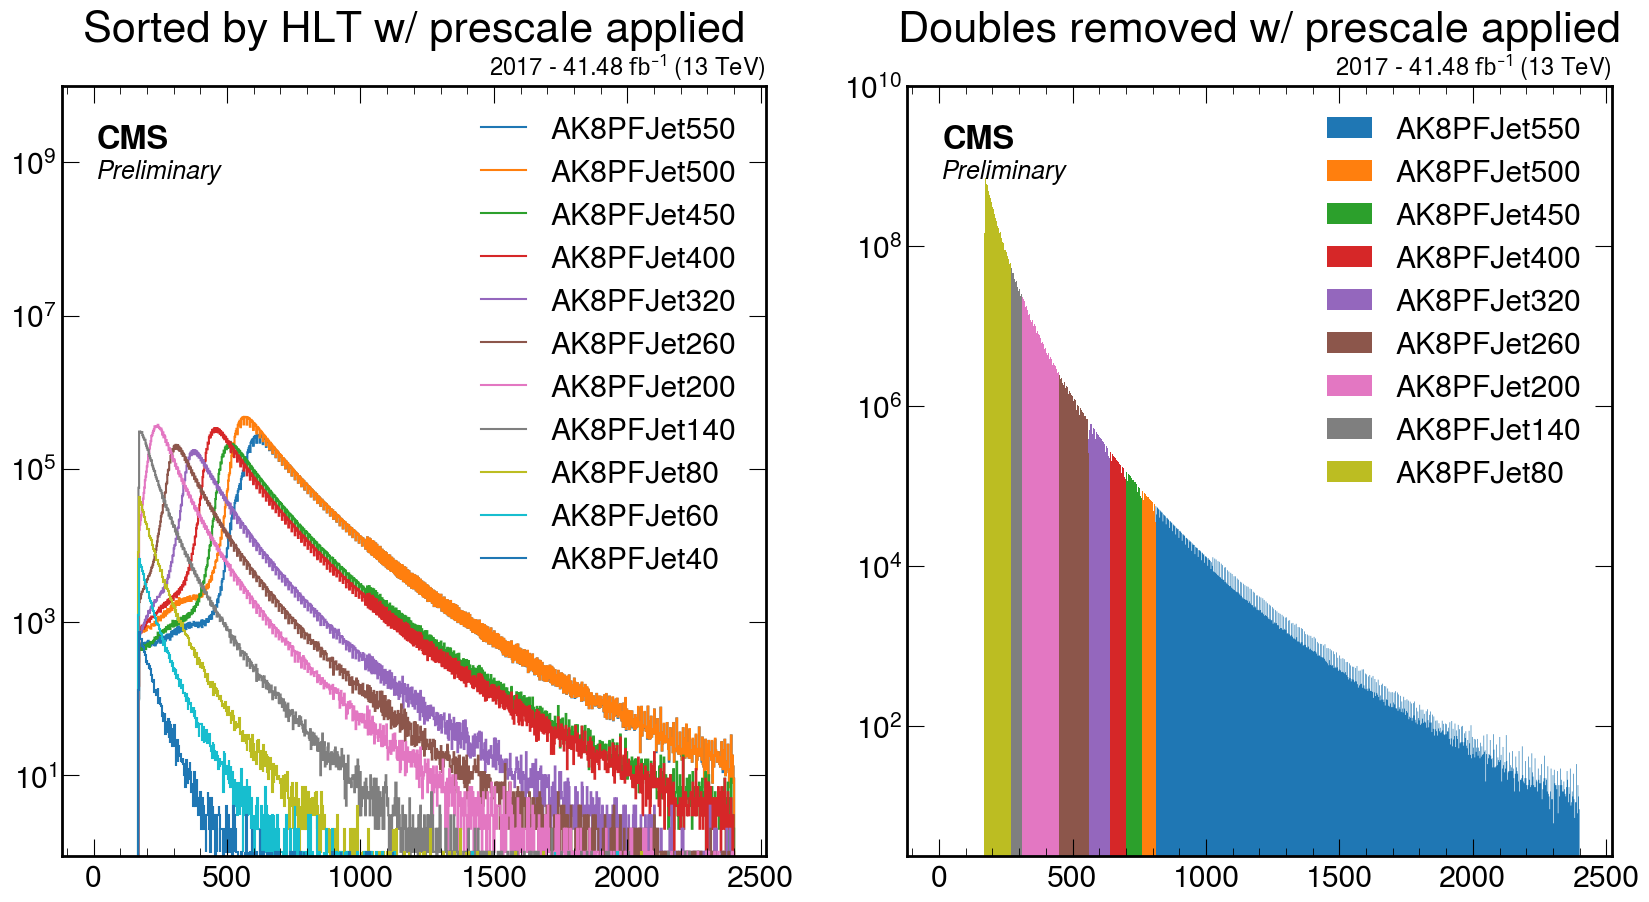

In [22]:
with open("coffeaOutput/applyPrescalesL1_JetHT_2017_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2017', label=r'2017 - 41.48',)

Hist(
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=5.60271e+07, variance=5.60271e+07) (WeightedSum(value=5.60302e+07, variance=5.60302e+07) with flow)
(StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'), Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'))


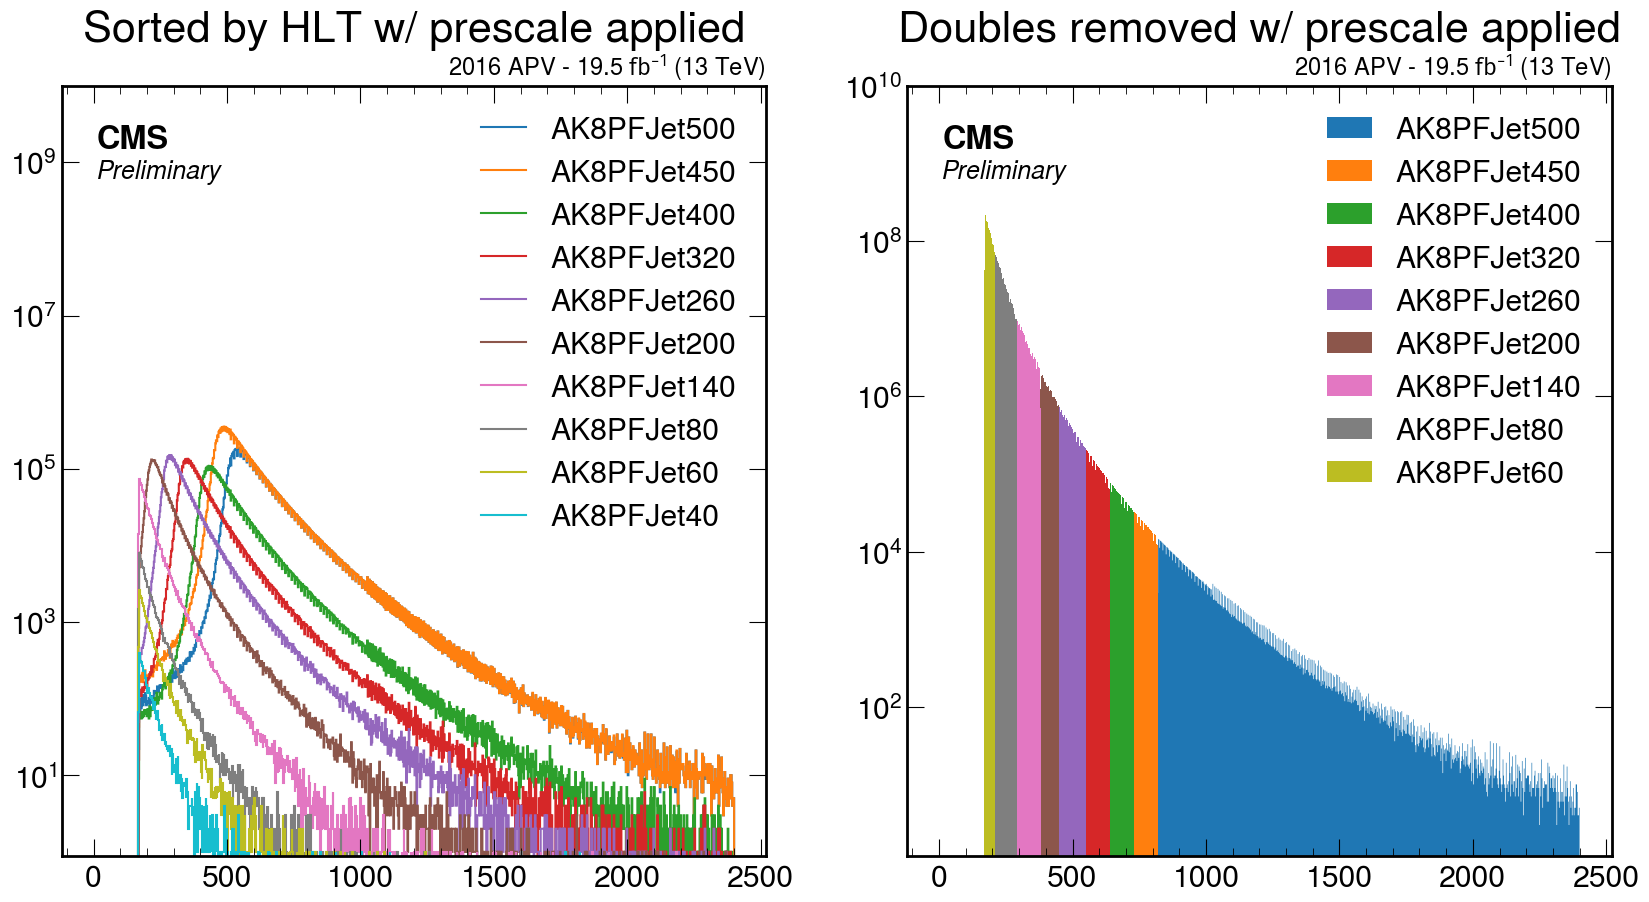

In [23]:
with open("coffeaOutput/applyPrescalesL1_JetHT_2016APV_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2016APV', label=r'2016 APV - 19.5')

Hist(
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.23984e+08, variance=1.23984e+08) (WeightedSum(value=1.23992e+08, variance=1.23992e+08) with flow)
(StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'), Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'))


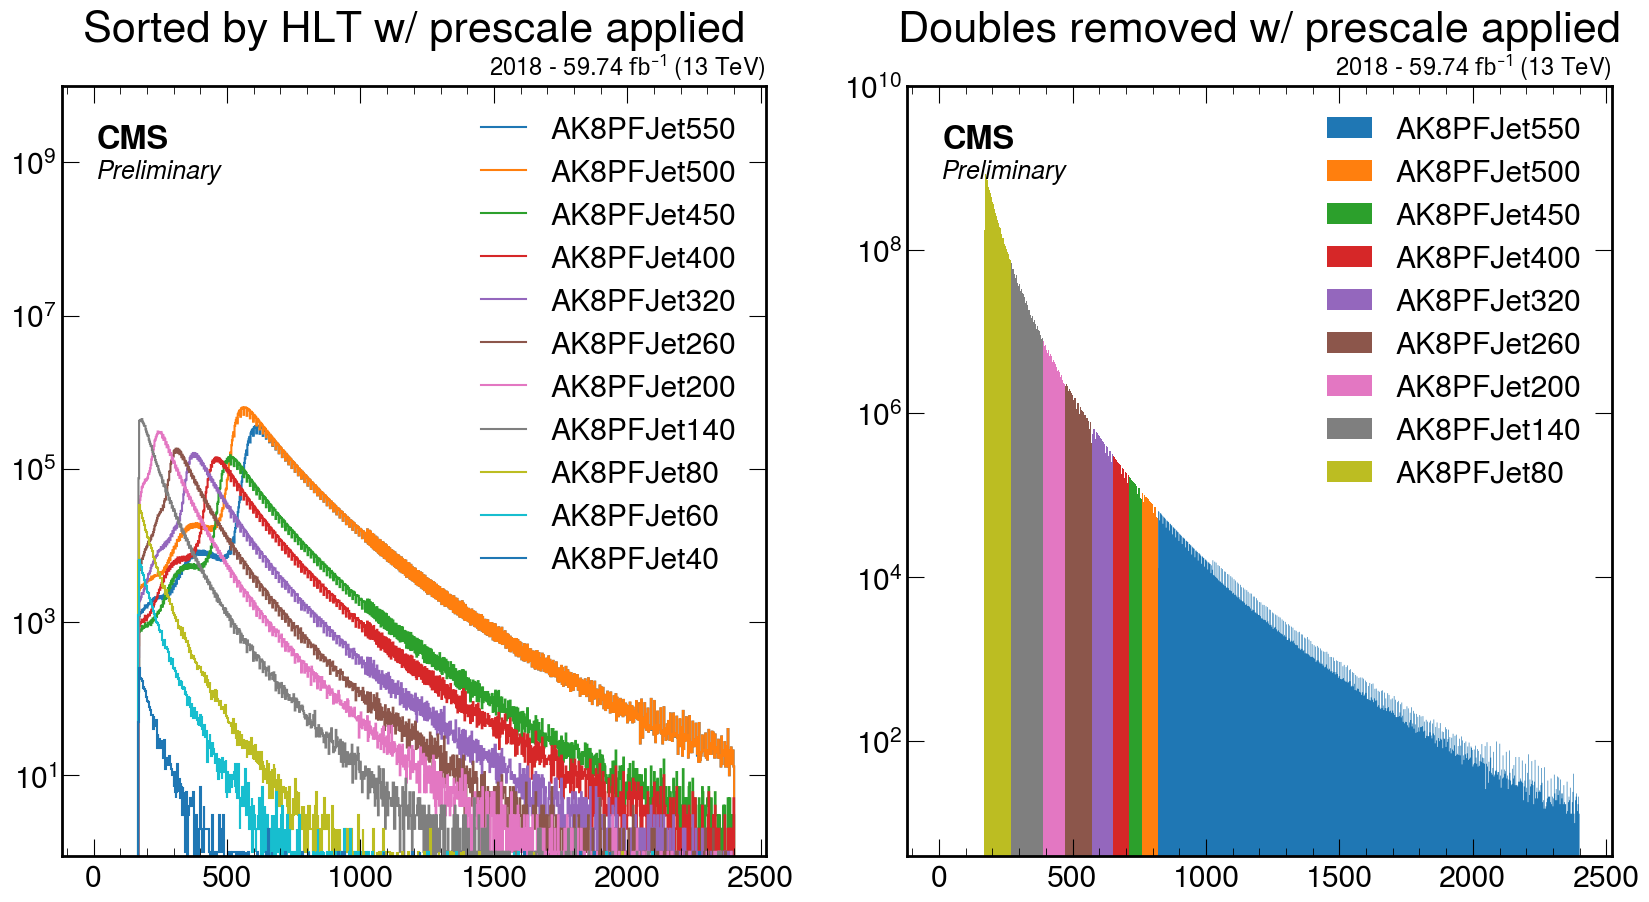

In [24]:
with open("coffeaOutput/applyPrescalesL1_JetHT_2018_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2018', label=r'2018 - 59.74',)